In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB


pd.set_option('display.max_colwidth', -1)

data = pd.read_csv("telecom_churn_data.csv")
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [2]:
data.dropna(axis = 1, how = 'all', inplace = True)
data.dropna(how='all', inplace=True)
data.shape

(99999, 226)

In [3]:
data.update(data[['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9']].fillna(0))
data.update(data[['av_rech_amt_data_6','av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']].fillna(0))
data.update(data[['max_rech_data_6','max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9']].fillna(0))
data.update(data[['count_rech_2g_6','count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9']].fillna(0))
data.update(data[['count_rech_3g_6','count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9']].fillna(0))
data.update(data[['night_pck_user_6','night_pck_user_7', 'night_pck_user_8', 'night_pck_user_9']].fillna(0))
data.update(data[['arpu_3g_6','arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9']].fillna(0))
data.update(data[['arpu_2g_6','arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9']].fillna(0))
data.update(data[['fb_user_6','fb_user_7', 'fb_user_8', 'fb_user_9']].fillna(0))

In [4]:
data.isnull().sum()

mobile_number     0   
circle_id         0   
loc_og_t2o_mou    1018
std_og_t2o_mou    1018
loc_ic_t2o_mou    1018
                  ... 
aon               0   
aug_vbc_3g        0   
jul_vbc_3g        0   
jun_vbc_3g        0   
sep_vbc_3g        0   
Length: 226, dtype: int64

In [5]:
data.update(data[['loc_og_t2o_mou','loc_ic_t2o_mou','std_og_t2o_mou']].fillna(0))

In [6]:
CAT = 'categorical'
NUM = 'numerical'

def get_col_type(col):
    cols = data.columns
    num_cols = data._get_numeric_data().columns
    if(col in num_cols):
        if('night_pck'==col[0:9] or 'fb_user'==col[0:7] or 'sachet' == col[0:6]):
            return CAT
        else:
            return NUM
    else:
        return CAT

def generate_null_dataframe(data):
    null_df = pd.DataFrame(data.isnull().sum()*100/len(data), columns=['na_perc'])
    null_df['column'] = null_df.index
    null_df.index = range(0,len(null_df['column']))
    null_df['col_type'] = null_df['column'].map(get_col_type)
    null_df = null_df[null_df.na_perc > 0]
    return null_df

def impute_cols_perc(null_df, data, perc):
    ndf = null_df.copy()
    ndf = ndf[ndf.na_perc > perc] 
    for index, row in ndf.iterrows():
        colname = row['column']
        if(CAT == row['col_type'] and 'date' != colname[0:4]):
            data[colname] = data[colname].fillna(-1)
        else:
            data[colname] = data[colname].fillna(0)

def impute_with_mode(data, cols):
    for column in cols:
        data[column].fillna(data[column].mode()[0], inplace=True)
        
cols = [c for c in data.columns if c[0:18] == 'last_date_of_month']
impute_with_mode(data, cols)
null_df = generate_null_dataframe(data)
null_df

,na_perc,column,col_type
13,3.937039,onnet_mou_6,numerical
14,3.859039,onnet_mou_7,numerical
15,5.378054,onnet_mou_8,numerical
16,7.745077,onnet_mou_9,numerical
17,3.937039,offnet_mou_6,numerical
...,...,...,...
152,4.760048,date_of_last_rech_9,categorical
157,74.846748,date_of_last_rech_data_6,categorical
158,74.428744,date_of_last_rech_data_7,categorical
159,73.660737,date_of_last_rech_data_8,categorical


In [7]:
data.drop(['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8', 
           'date_of_last_rech_data_9'], axis=1, inplace=True)

In [8]:
#understanding data and renaming confusing column names
data = data.rename(columns={'aug_vbc_3g': 'vbc_3g_8', 'jun_vbc_3g': 'vbc_3g_6', 'jul_vbc_3g': 'vbc_3g_7', 
                            'sep_vbc_3g': 'vbc_3g_9'})

In [10]:
data['total_rech_6'] = (data['av_rech_amt_data_6']*data['total_rech_data_6']) + data['total_rech_amt_6']
data['total_rech_7'] = (data['av_rech_amt_data_7']*data['total_rech_data_7']) + data['total_rech_amt_7']
data['total_rech_8'] = (data['av_rech_amt_data_8']*data['total_rech_data_8']) + data['total_rech_amt_8']
data['avg_rech_amt_6_7'] = (data['total_rech_6'] + data['total_rech_7'])/2

perct_70 = data['avg_rech_amt_6_7'].quantile(0.7)
perct_70

478.0

In [11]:
#churn value = rate at which customers stop doing business with a company over a given period of time
def churn(row):
    if ((row['total_ic_mou_9'] == 0) & (row['total_og_mou_9'] == 0) & (row['vol_2g_mb_9'] == 0) & (row['vol_3g_mb_9'] == 0)):
        return 1
    else:
        return 0
    
data['churn'] = data.apply(churn, axis=1)
data.groupby('churn')['churn'].count()

churn
0    89808
1    10191
Name: churn, dtype: int64

In [12]:
null_df = generate_null_dataframe(data)
null_df

,na_perc,column,col_type
13,3.937039,onnet_mou_6,numerical
14,3.859039,onnet_mou_7,numerical
15,5.378054,onnet_mou_8,numerical
16,7.745077,onnet_mou_9,numerical
17,3.937039,offnet_mou_6,numerical
...,...,...,...
136,7.745077,ic_others_9,numerical
149,1.607016,date_of_last_rech_6,categorical
150,1.767018,date_of_last_rech_7,categorical
151,3.622036,date_of_last_rech_8,categorical


In [13]:
# Removing Outliers 
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~(((data < (Q1 - (3 * IQR))) |(data > (Q3 + (3 * IQR)))).sum(axis=1) > 20)]
data.shape

(64332, 227)

In [14]:
data_churn = data[data['churn'] == 1]
data_nochurn = data[data['churn'] == 0]
data_churn.total_og_mou_8.describe()

count    8695.000000
mean     59.058010  
std      184.779395 
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      14.085000  
max      3864.680000
Name: total_og_mou_8, dtype: float64

In [17]:
def uni_quant(df, var):
    """
    Method that takes in the dataframe and a quantitaive variable and gives out the univariate analysis.
    
    @Author- Aryan Singh
    """
    plt.figure(figsize=(14,12))
    sb.set(font_scale=1)
    plt.subplot(121)
    sb.distplot(df[var])
    plt.subplot(122)
    sb.boxplot(y=var,data=df)
    plt.show()
    

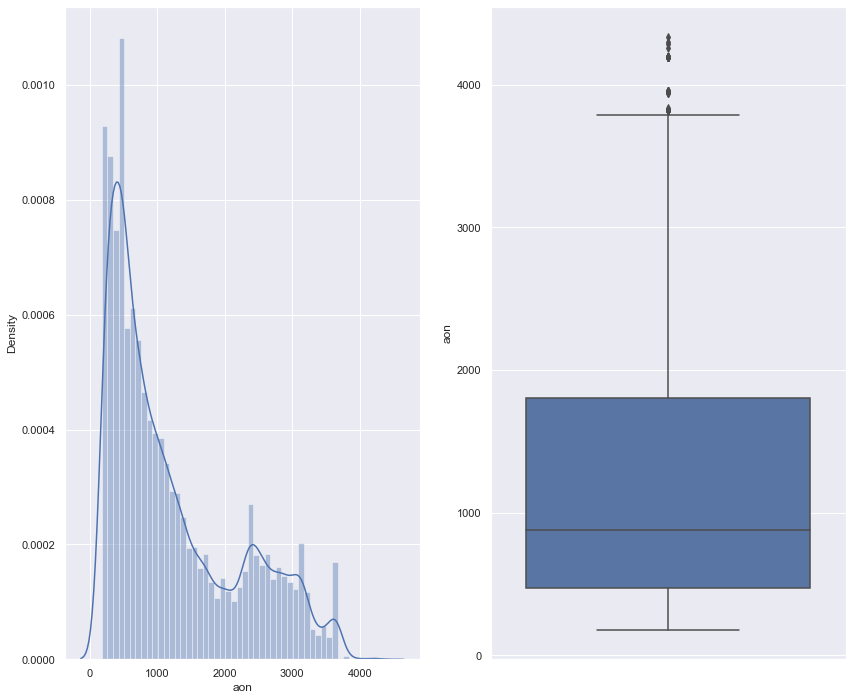

In [18]:
uni_quant(data,'aon')

In [21]:
CHURN = 'churn'
cols_avg_6_7 = [c for c in data.columns if(c[-8:] == '_avg_6_7' or CHURN == c)]
#cols7 = [c for c in data.columns if(c[-2:] == '_7' or CHURN == c)]
cols8 = [c for c in data.columns if(c[-2:] == '_8' or CHURN == c)]
miscc_cols = [c for c in data.columns if (c[-2:] != '_6' and c[-2:] != '_7' and c[-2:] != '_8' 
                                          and c[-8:] != '_avg_6_7' ) and c != 'mobile_number']

data_avg_6_7 = data[cols_avg_6_7]
plt.figure(figsize=(15,15))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<AxesSubplot:>

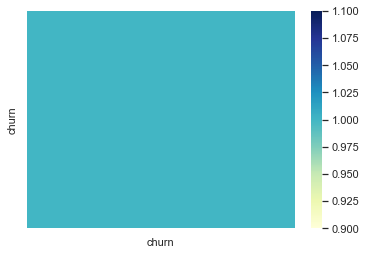

In [22]:
# Create correlation matrix
corr = data_avg_6_7.corr()
sb.set(font_scale=1)
sb.heatmap(corr, cmap="YlGnBu", annot=False)

In [30]:
#Using Z score
outliers=[]
def detect_outliers(data):
    
    threshold=3
    mean = np.mean(data)
    std =np.std(data)
    
    
    for i in data:
        z_score= (i - mean)/std 
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

In [31]:
outlier_pt=detect_outliers(data.aon)
outlier_pt

[4192,
 4194,
 4337,
 4197,
 4192,
 4260,
 4193,
 4197,
 4193,
 4193,
 4197,
 4197,
 4197,
 4197,
 4299,
 4195,
 4197,
 4197,
 4193,
 4193,
 4192,
 4282,
 4193,
 4193,
 4192]

In [34]:
## Performing steps of IQR
sorted(outlier_pt)

[4192,
 4192,
 4192,
 4192,
 4193,
 4193,
 4193,
 4193,
 4193,
 4193,
 4193,
 4194,
 4195,
 4197,
 4197,
 4197,
 4197,
 4197,
 4197,
 4197,
 4197,
 4260,
 4282,
 4299,
 4337]

In [36]:
quantile1, quantile3= np.percentile(outlier_pt,[25,75])
print(quantile1,quantile3)

4193.0 4197.0


In [37]:
iqr_value=quantile3-quantile1
print(iqr_value)

4.0


In [39]:
lower_bound_val = quantile1 -(1.5 * iqr_value) 
upper_bound_val = quantile3 +(1.5 * iqr_value) 
print(lower_bound_val,upper_bound_val)

4187.0 4203.0
